In [1]:
import pickle
from pandas import DataFrame
from pandas import Series
import pandas
from datetime import datetime, timedelta
from math import isnan
import random
from math import nan
from typing import Any
import matplotlib.pyplot as plt


import numpy as np

pandas.options.mode.copy_on_write = True # Helps reduce redundant copying where possible
pandas.set_option("future.no_silent_downcasting", True) # Forward compatible warning

# Load the dataset
try:
    with open("data/bloomData.pkl", "rb") as dataPickle:
        fullData: DataFrame = pickle.load(dataPickle, fix_imports=True)
except:
    fullData = DataFrame()

Goals

* [] Temporal Analysis of Cheating Spread
* [] Predictive Modelling of Cheating Risk
* [] Game ownership analysis
* [] Playtime analysis

## Synthesizing information from data

First we filter out the data that isn't necessary in my usage.

In [2]:
# Replace EconomyBan to a boolean column
fullData:DataFrame = fullData.replace({"EconomyBan": {"banned": True, "none": False}}).infer_objects(copy=False)

data:DataFrame = fullData.loc[
    :,
    [
        "communityvisibilitystate",
        "personastate",
        "timecreated",
        "CommunityBanned",
        "NumberOfVACBans",
        "DaysSinceLastBan",
        "NumberOfGameBans",
        "EconomyBan",
        "friendsList",
        "ownedGames",
        "groups",
        "recentlyPlayed",
        "commentpermission",
        "loccountrycode",
        "avatar",
        "gameid"
    ],
]

We can summarize all bans into a single "misdemeanor count" column. This is based on the assumption that all ban types on Steam contributes to whether a player is likely to cheat in the future. This is similar to how Valve determines the ["Trust Factor"](https://help.steampowered.com/en/faqs/view/00EF-D679-C76A-C185) of a player, which they use to protect high trust players from potentially low trust players, improving match quality.

In [3]:
data["MisdemenourCount"] = (
    data["NumberOfVACBans"]
    + data["NumberOfGameBans"]
    + data["CommunityBanned"].apply(lambda b: 1 if b else 0)
    + data["EconomyBan"].apply(lambda b: 1 if b else 0)
)

We then convert the relative timestamp of the players last ban time to an absolute timestamp. This allows us to avoid conversion through this process

In [4]:
currentTimestamp = datetime.now()
data["LastBanTime"] = data.apply(
    lambda x: (
        (currentTimestamp - timedelta(x["DaysSinceLastBan"])).timestamp()
        if (x["NumberOfVACBans"] + x["NumberOfGameBans"])
        else None
    ),  # type:ignore
    axis=1,
)

Unfortunately, we only have the timestamp for the latest ban given to a player. Due to privacy reasons we may not even have information of when a player created their Steam account, hindering our ability to synthesize ban times in the correct time range.

We want to provide a decent estimate of the exact ban instance of each cheater. We do have the total number of game bans, which includes both bans made by the Valve Anti-Cheat system (VAC), and manual bans given by other cheat detection methods such as third party cheat detectors or user review.

We perform the following steps to synthesize the timestamps for each cheating instances for a given player

* Iff we have information account creation time, that is set as the earliest possible ban time
* Iff the player's account doesn't have data on the account creation time, then we estimate the earliest possible ban time by assuming ban intervals are distributed equally
  * The earliest possible ban time is bounded to $[2023/09/12, \inf]$, the earliest known time VAC 2.0 is in effect, which is when VAC bans became permanent.
  * The creation time will also take into account known friendships, so that the earliest possible ban time is equal or earlier to the first known friendship

$$
\begin{aligned}
    \mathrm{earliestPossibleBanTime} = \mathrm{max}(&\mathrm{min}(\mathrm{lastBan} - \mathrm{timeSinseLastBan} * \mathrm{numBans}, \mathrm{earliestFriendshipTime}),\\
    & \mathrm{VACLaunchDate})
\end{aligned}
$$

Knowing both the account creation time, and the latest ban time, we can then generate ban times for a user based on a uniform distribution. We also include the user creation times and the latest ban times at the start and the end of the list for use later.

$$
\begin{aligned}
    \mathrm{times}_0 &= \mathrm{earliestPossibleBanTime} \\
    \mathrm{times}_i &= X \sim U_{[\mathrm{earliestPossibleBanTime}, \mathrm{lastBanTime}]} & \forall i \in \{ 1, \cdots, \mathrm{numBans}-1\} \\
    \mathrm{times}_{\mathrm{numBans}} &= \mathrm{lastBanTime}
\end{aligned}
$$



In [5]:
from math import inf


EARLIESTPOSSIBLEBAN = datetime(2003, 9, 12).timestamp()


def synthesizeEventTimes(x):
    numBans: int = x["NumberOfVACBans"] + x["NumberOfGameBans"]

    if numBans == 0:
        return []

    lastBan: float = x["LastBanTime"]
    timeCreated: float = x["timecreated"]
    earliestPossibleBanTime = timeCreated
    
    # timeCreated is not available
    #
    # Assumption made:
    #   The criminals activity is spaced based on a uniform  distribution centred around the last ban time
    if isnan(timeCreated):
        friendshipTimes = [f["friends_since"] for f in x["friendsList"] if f["friends_since"] != 0]

        earliestFriendshipTime = min(friendshipTimes) if len(friendshipTimes) > 0 else inf

        timeSinceLastBan = x["DaysSinceLastBan"]
        earliestPossibleBanTime = max(min(lastBan - timeSinceLastBan * numBans, earliestFriendshipTime), EARLIESTPOSSIBLEBAN)


    banRange = lastBan - earliestPossibleBanTime
    times = [lastBan - random.uniform(0, 1) * banRange for i in range(0, numBans)]

    times.sort()
    times.append(lastBan)

    return times

data["synthesizedTimes"] = data.apply(synthesizeEventTimes, axis=1)

One can notice that for cheaters, we actually generate one extra ban instance. This $0^{th}$ ban time will actually be used as one of three estimations for the account creation time of players who doesn't have any data on when their account was created

In [6]:
# First time is the creation time
# Any subsequent times are ban times
data["synthesizedTimes"] = data.apply(synthesizeEventTimes, axis=1)

# Try to get the existience 
def getLatestTime(x :dict[str, Any]):
    latestBanTime = x["LastBanTime"]
    if not isnan(latestBanTime):
        return latestBanTime
    
    timecreated = x["timecreated"]

    if(not isnan(timecreated)):
        return timecreated
    
    return None


earliestTime = data.loc[:, ["timecreated"]].dropna()
latestTime = np.max(data.apply(getLatestTime, axis=1)) #type:ignore

validTimeMax = np.max(latestTime)
validTimeMin = np.min(earliestTime)
validTimeRange = validTimeMax - validTimeMin

def populateCreationTimes(x : dict[str, Any]):
    timecreated = x["timecreated"]

    # We already have the information we need
    if(not isnan(timecreated)):
        return timecreated
    
    synthesizedTimes = x["synthesizedTimes"]

    friendshipTimes = [f["friends_since"] for f in x["friendsList"] if f["friends_since"] != 0]

    # Take the earliest known friendship if available
    earliestFriendshipTime = min(friendshipTimes) if len(friendshipTimes) > 0 else inf
    # And the earliest guess of ban time if available
    earliestBanTime = inf if len(synthesizedTimes) == 0 else synthesizedTimes[0]
    # And a guess based around a population based on a uniform distribution
    uniformDistGuess = validTimeMin + validTimeRange * random.random()

    # And take the minimum between all three
    timecreatedGuess = min([uniformDistGuess, earliestBanTime, earliestFriendshipTime])

    
    return timecreatedGuess

data["timecreated"] = data.apply(
    populateCreationTimes, # type:ignore
    axis=1,
)

data["EstimatedBanTimes"] = data.apply(
    lambda x: x["synthesizedTimes"][1:] if len(x["synthesizedTimes"]) > 0 else [],
    axis=1,
)

# Remove synthesizedTimes column
data.drop("synthesizedTimes", axis = 1, inplace=True)

## Temporal analysis of cheating spread

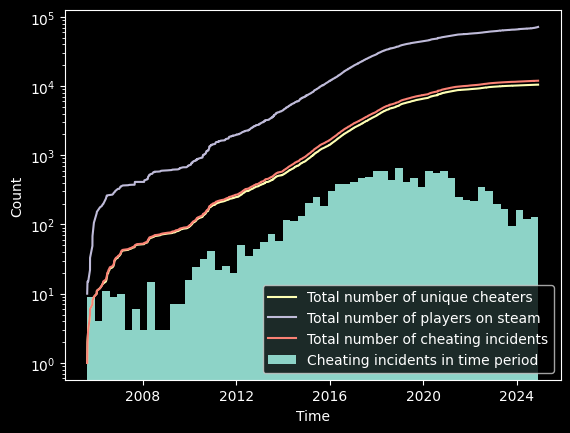

In [37]:
cheatingIncidents = []

uniqueCheaters = set()
numUniqueCheaters = []
numPlayers = []

count = 0

for i, e in data.sort_values("timecreated").iterrows(): 
    count+=1
    steamId = i
    banTimes  = e["EstimatedBanTimes"]

    for t in banTimes:
        cheatingIncidents.append((t, i))
        numPlayers.append(count)

    if(len(banTimes) == 0):
        continue

cheatingIncidents.sort(key = lambda x : x[0])

cheatingTimes = []
cheatingCount = [i+1 for i in range(len(cheatingIncidents))]
for t in cheatingIncidents:
    cheatingTimes.append(datetime.fromtimestamp(t[0]))
    uniqueCheaters.add(t[1])
    numUniqueCheaters.append(len(uniqueCheaters))

plt.hist(cheatingTimes, log=True, bins="auto")
plt.xlabel("Time")
plt.ylabel("Count")
plt.plot(cheatingTimes,numUniqueCheaters)
plt.plot(cheatingTimes,numPlayers)
plt.plot(cheatingTimes,cheatingCount)
plt.legend(["Total number of unique cheaters", "Total number of players on steam", "Total number of cheating incidents", "Cheating incidents in time period"])
plt.show()

By plotting the number of cheating incidents, the number of unique cheaters, and the total number of players on Steam. We can observe that as time passes, the number of users increases significantly. The number of unique cheaters increase in a significantly lower rate.

The total number of cheating incidents grows in the same fashion as the number of unique cheaters. Suggesting the most caught cheaters never cheat again (or at least get caught doing so), or they abandon their Steam account.

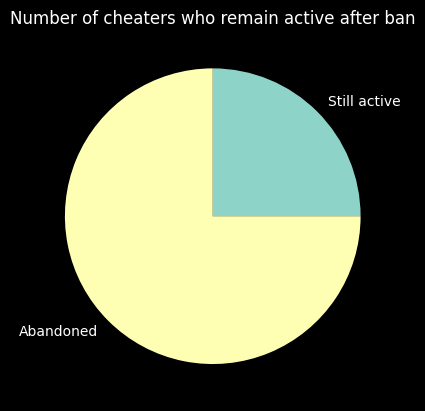

In [36]:
from pandas import isnull


cheaters = data.loc[(data["NumberOfVACBans"] + data["NumberOfGameBans"]) > 0, :]


def isActive(x: dict[str, Any]):
    if x["NumberOfVACBans"] + x["NumberOfGameBans"] > 1:
        return True

    if not pandas.isnull(x["gameid"]) :
        return True

    recentlyPlayed: dict[str, Any] = x["recentlyPlayed"]

    activity =  recentlyPlayed.get("total_count", 0) > 0

    
    return activity


numberOfCheaters = len(cheaters)
activeCheaters= cheaters.apply(isActive, axis=1)

numberOfActiveCheaters : int = activeCheaters.values.sum() # type:ignore
numberOfInactiveCheaters : int = numberOfCheaters - numberOfActiveCheaters


plt.pie([numberOfActiveCheaters, numberOfInactiveCheaters], labels=["Still active", "Abandoned"])
plt.title("Number of cheaters who remain active after ban")
plt.show()